In [1]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import collections 
def makehash():
    return collections.defaultdict(makehash)
import fnmatch 
import torch 
from tqdm import tqdm 
from utils import save_dir, analyze_dir, result_dir,train_pool
import scipy.spatial.distance as dist
from tqdm import tqdm
import re
from sklearn.manifold import TSNE

def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [2]:
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
#epochs-10_batch-32_lr-0.001_momentum-0.5_init-gaussian_std-0.0001
#                           epochs-10_batch-32_lr-0.002_momentum-0.6_init-gaussian_std-1e-05 \
#                           epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06 

In [3]:
# load training data 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

In [4]:
grad_pkl_files = []
for file in os.listdir(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*gradient_data.pkl'):
        grad_pkl_files.append(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier,file))
s = [re.findall('/\d+', x) for x in grad_pkl_files]
s = [item for sublist in s for item in sublist]
dummy_id = [(x.split('/')) for x in s]
file_id = [int(x.split('/')[1]) for x in s]
sorted_files = [grad_pkl_files[x] for x in np.argsort(file_id)]
grad_pkl_files=sorted_files

## Hierarchical accuracies

In [5]:
hier_accu=[]
test_predictions=[]
test_probabilites=[]
test_grad_dict=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
    test_predictions.append([test['target_test'], test['pred_test']])
    test_probabilites.append( test['pred_test_prob'])
    test_grad_dict.append(test['grad_dict'])
    
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [00:31, 33.23it/s]


In [53]:
np.asarray(epochs)

array([ 1,  1,  1, ..., 10, 10, 10])

In [63]:
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*np.asarray(epochs)+np.asarray(batches)
x_bar= np.arange(len(epoch_batch))/len(epoch_batch)
epoch_bar=np.argwhere(np.diff(np.asarray(epochs)))/(len(epoch_batch))
epoch_bar

array([[0.0990566],
       [0.1990566],
       [0.2990566],
       [0.3990566],
       [0.4990566],
       [0.5990566],
       [0.6990566],
       [0.7990566],
       [0.8990566]])

In [65]:
x_bar

(1060,)

In [72]:
params = train_pool[model_identifier]()
params.load_dataset()



<HDF5 dataset "data": shape (128252,), type "|u1"> is not a matlab type
<HDF5 dataset "ir": shape (128252,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (64128,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32


In [75]:
layer_names = params.get_layer_names()[3:]
layer_names

['layer_3_Linear']

In [17]:
gradient_pool_files=[]
for file in os.listdir(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*_gradient_pooled.pkl'):
            gradient_pool_files.append(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier,file))

In [76]:
gradient_results=pickle.load(open(gradient_pool_files[0],'rb'))
gradient_results=gradient_results['gradient_results']

(0.0, 1.0)

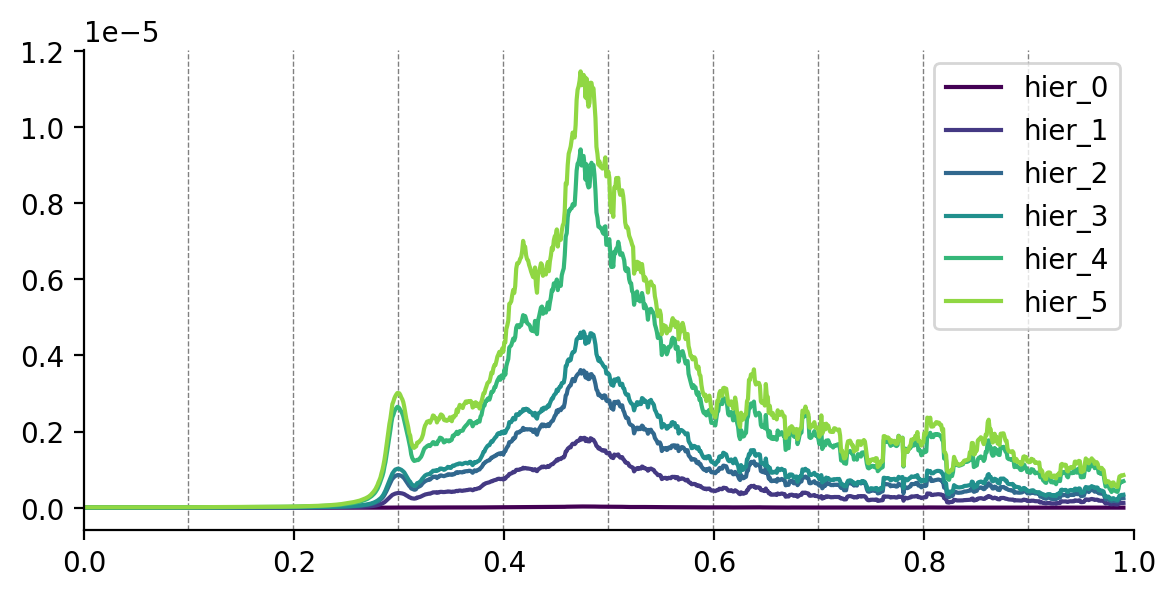

In [77]:
xmin=0
xmax=1
av_window=20
num_colors=len(gradient_results.keys())+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
fig=plt.figure(1,figsize=(15,12),dpi=200,frameon=False)
ax1=plt.axes((.05,.7,.35,.2))
for idx,key in enumerate(gradient_results.keys()):
    ax1.plot(moving_average(x_bar,av_window),moving_average(np.mean(gradient_results[key],axis=1),av_window),label=key,color=line_cols[idx,:])
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend()
ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.autoscale(enable=True, axis='y', tight=True)
ax1.set_xlim((xmin,xmax))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


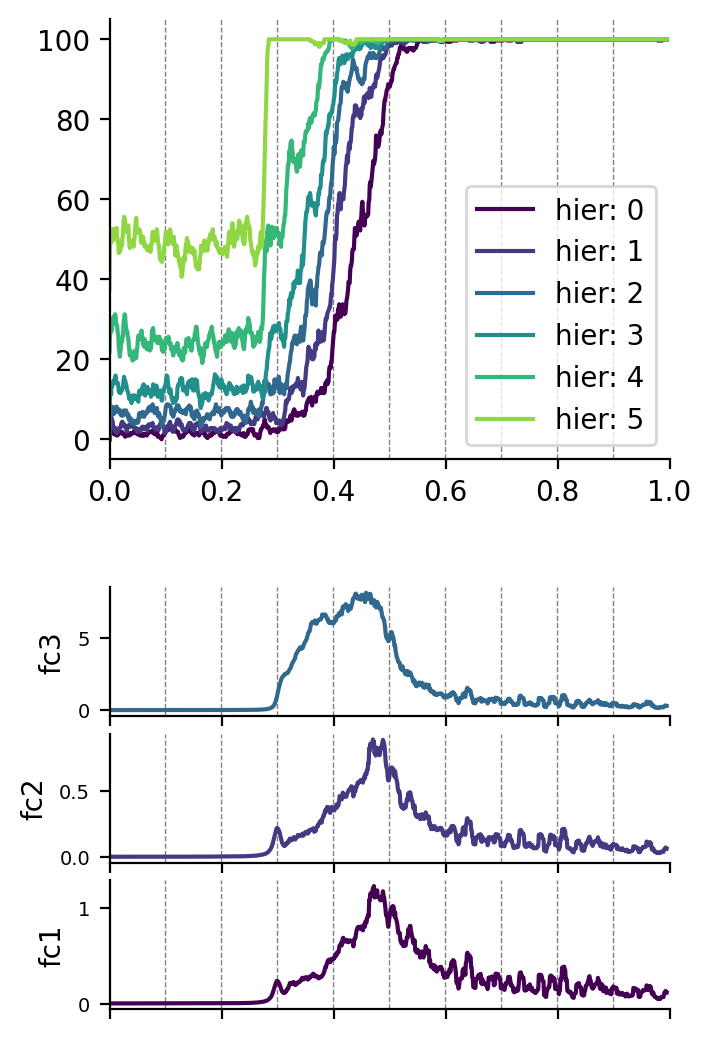

In [51]:
xmin=0
xmax=1
num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))


fig=plt.figure(1,figsize=(8,11),dpi=200,frameon=False)
ax1=plt.axes((.05,.7,.35,.2))
#ax1.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,0],av_window),label='entities',color=line_cols[0,:])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.set_ylabel('classification accuracy')
#ax1.set_title(f"{model_identifier}\n{train_identifier}",fontsize=8)
#ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
#ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.autoscale(enable=True, axis='y', tight=True)
#ax1.set_xlim((xmin,xmax))

#ax2=plt.axes((.05,.45,.35,.2))
ax2=plt.axes((.05,.7,.35,.2))
for h in range(accuracies.shape[1]):
        ax2.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='y', tight=True)
ax2.set_xlim((xmin,xmax))


axis_split=accuracies.shape[1]

for h in range(all_grad.shape[1]):
    ax2=plt.axes((.05,.45+h*.4/axis_split,.35,.4/axis_split-0.008))


    ax2.plot(moving_average(x_bar,av_window),moving_average(all_grad[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.axes.xaxis.set_ticklabels([])
    ax2.set_ylabel(all_grad_names[h])
    #ax2.axes.yaxis.set_ticklabels([])
    #ax2.axes.yaxis.set_ticklabels(ax2.get_ticklabels())
    plt.setp(ax2.get_yticklabels(), fontsize=7)
#ax2.legend()
    ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.autoscale(enable=True, axis='y', tight=True)
    ax2.set_xlim((xmin,xmax))
